<a href="https://colab.research.google.com/github/Diederickvanderlee/week-4/blob/master/diederickvanderlee_week_4_Siraj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Make sure runtime type is set to GPU for better parallel processing

import os, random, gc, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import tensorflow as tf
import keras_preprocessing.image
import tensorflow.keras.backend as k
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.utils import class_weight
from PIL import Image
from google.colab import drive

# Configuration
%matplotlib inline

is_pretrained = True # Trained with locked base_model
keep_training = False # Additional unlocked layers
batch_size = 39
width = 640
height = 480
learning_rate = 1e-2
proj_dir = '/content/gdrive/My Drive/data'

# Google Drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
xray_path = '{}/ChestXRay2017.zip'.format(proj_dir).replace(' ', '\\ ')
!unzip $xray_path

Archive:  /content/gdrive/My Drive/data/ChestXRay2017.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person124_bacteria_589.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person1647_virus_2848.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person1675_virus_2891.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person89_bacteria_440.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person35_virus_80.jpeg  
  inflating: chest_xray/test/P

In [4]:
def dir_file_count(directory,filetype):
  total_files = 0
  for root, dirs, files in os.walk(".", topdown=False):
    total_files += len(list(filter(lambda x: x.endswith(filetype), files)))
  return total_files

def xray_process(im):
  # X-Rays are negative images. Imagenet was trained on normal images.
  im = 255. - im

  # Imagenet tensorflow samples are scaled between -1 (black) and 1 (white)
  # https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
  im /= 255.
  im -= .5
  im *= 2.
  return im

target_size = (height, width)
class_mode = 'categorical'
training_dir = './chest_xray/train'
testing_dir = './chest_xray/test'

train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=xray_process)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    interpolation='bicubic',
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)

Found 5232 images belonging to 2 classes.


Create a separate testset using the same methodology but with a different set

In [5]:
test_datagen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                  preprocessing_function=xray_process)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    interpolation='bicubic',
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=False)

Found 624 images belonging to 2 classes.


In [6]:
def get_weight(y):
    class_weight_current = class_weight.compute_class_weight('balanced',
                                                             np.unique(y), y)
    return class_weight_current

class_w = get_weight(train_generator.classes)
print(class_w)

[1.93921423 0.6737059 ]


In [0]:
def get_image_set(image_set, image_type):
  def get_image_path(path_pre, image_name):
    return '{}/{}/{}/{}'.format(path_pre, image_set, image_type, image_name)

  path_pre = './chest_xray'
  image_list = os.listdir('{}/{}/{}'.format(path_pre, image_set, image_type))
  image_list = list(map(lambda x: get_image_path(path_pre, x), image_list))

  # Ignore .DS_Store files
  image_list = list(filter(lambda x: x.endswith('.jpeg'), image_list))
  return image_list

tr_normal = get_image_set('train', 'NORMAL')
tr_pneumonia = get_image_set('train', 'PNEUMONIA')

te_normal = get_image_set('test', 'NORMAL')
te_pneumonia = get_image_set('test', 'PNEUMONIA')

images_normal = tr_normal + te_normal
images_pneumonia = tr_pneumonia + te_pneumonia
images_pneumonia_bacterial = [img for img in images_pneumonia
                              if img.split('/')[-1].split('_')[1] == 'bacteria']
images_pneumonia_viral = [img for img in images_pneumonia
                          if img.split('/')[-1].split('_')[1] == 'virus']

images_full = images_normal + images_pneumonia
images_test = te_normal + te_pneumonia

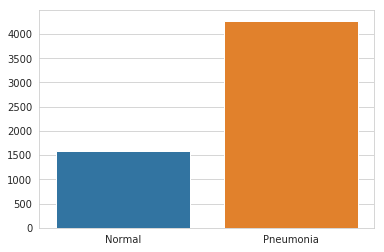

In [8]:
sns.set_style('whitegrid')
sns.barplot(x=['Normal', 'Pneumonia'],
            y=[len(images_normal),
               len(images_pneumonia)])


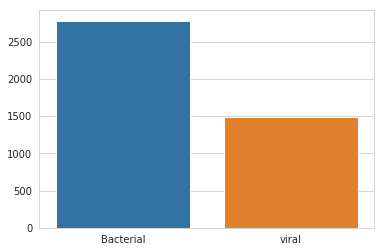

In [9]:
sns.set_style('whitegrid')
sns.barplot(x=['Bacterial', 'viral'],
            y=[len(images_pneumonia_bacterial),
               len(images_pneumonia_viral)])

Create a grid with four random examples of diagnosis.
randomly select an image from imageset with specific label.

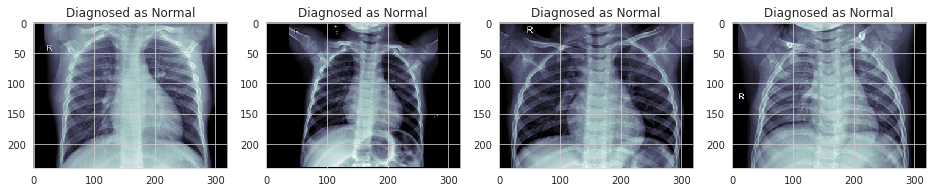

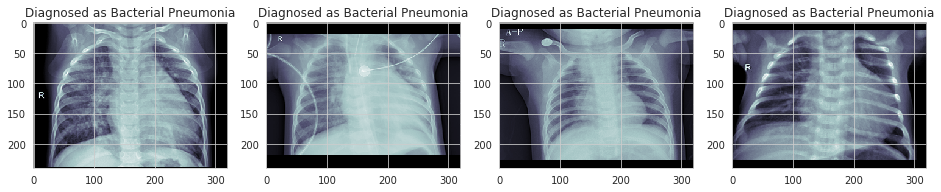

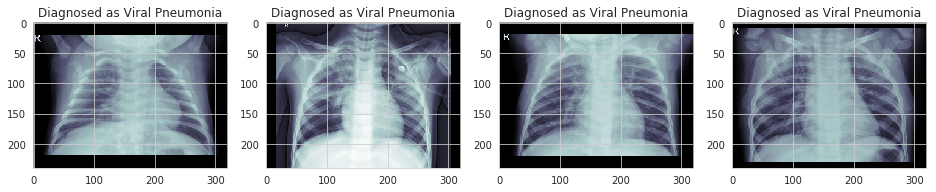

In [10]:
def get_image(path):
  return cv2.imread(path, 0)

def get_resized_image(path, width, height):
  im = Image.fromarray(get_image(path))
  im_w, im_h = im.size

  # Proportionally scale to be contained within canvas bounds.
  if im_w > width:
    im_h = int(width/im_w * im_h)
    im_w = width
  if im_h > height:
    im_w = int(height/im_h * im_w)
    im_h = height

  if [im_w, im_h] != list(im.size):
    im.thumbnail((im_w, im_h), Image.ANTIALIAS)

  # Return the image over a black background.    
  im_resized = Image.new('RGB', (width, height), (0, 0, 0))
  offset = ((width - im.size[0]) // 2,
            (height - im.size[1]) // 2)
  im_resized.paste(im, offset)

  return np.array(im_resized)

def plot_sample_xrays(image_set, image_label,
                      width=width//2, height=height//2,
                      rows=1, cols=4,
                      size_w=4, size_h=3):
  f,ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))

  for idx in range(rows*cols):
    i = random.randint(0, len(image_set)) 
    im = get_resized_image(image_set[i], width, height)[:, :, 0]
    ax[idx%cols].imshow(im, cmap='bone')
    ax[idx%cols].axis('on')
    ax[idx%cols].set_title('Diagnosed as {}'.format(image_label))
  plt.show()

plot_sample_xrays(images_normal, 'Normal')
plot_sample_xrays(images_pneumonia_bacterial, 'Bacterial Pneumonia')
plot_sample_xrays(images_pneumonia_viral, 'Viral Pneumonia')

In [0]:
def build_model(optimizer):
  base_model = InceptionV3(weights='imagenet', include_top=False,
                           input_shape=(height, width, 3)) 
  
  #Defining a custom head for network
  #stack a bunch of functions together
  x = base_model.output
  x = Dropout(0.4)(x)
  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x = Dropout(0.4)(x)
  x = Dense(16)(x)
  x = LeakyReLU()(x)
  x = Dropout(0.4)(x)
  p = Dense(len(class_w), activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=p)

  for layer in base_model.layers:
    layer.trainable = False

  model.compile(optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

  return model

In [12]:
model = build_model(SGD(learning_rate=learning_rate, momentum=0.9))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
87916544/87910968 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 239, 319, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 239, 319, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation

In [13]:
# Creates directory, if directory exists removes if remove parameter is True
def create_directory(directory_path, remove=False):
  if remove and os.path.exists(directory_path):
    try:
      shutil.rmtree(directory_path)
      os.mkdir(directory_path)
    except:
      print("Could not remove directory : ", directory_path)
      return False
  else:
    try:
      os.mkdir(directory_path)
    except:
      print("Could not create directory: ", directory_path)
      return False   
  return True
  print("folder %s created"%directory_path)

main_model_dir = '{}/models'.format(proj_dir)
m_dir = main_model_dir + '/' + time.strftime('%Y-%m-%d_%H-%M-%S') + '/'
ckp_path = m_dir + 'v_acc-{val_acc:.2f}-v_loss-{val_loss:.2f}.hdf5'
print(ckp_path)
create_directory(m_dir, remove=True)

checkpoint = ModelCheckpoint(ckp_path,
                             monitor='val_acc', 
                             save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              patience=2,
                              cooldown=2,
                              min_lr=1e-10,
                              verbose=1)
early_stopping = EarlyStopping(monitor='val_acc',
                               mode='max',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True)
callbacks = [checkpoint, reduce_lr, early_stopping]

/content/gdrive/My Drive/data/models/2019-09-29_07-24-40/v_acc-{val_acc:.2f}-v_loss-{val_loss:.2f}.hdf5


Epoch 1/10
135/135 [==============================] - 544s 4s/step - loss: 0.2884 - acc: 0.8786 - val_loss: 0.7140 - val_acc: 0.6250
Epoch 2/10
135/135 [==============================] - 459s 3s/step - loss: 0.2132 - acc: 0.9136 - val_loss: 0.8282 - val_acc: 0.6250
Epoch 3/10
134/135 [============================>.] - ETA: 2s - loss: 0.1923 - acc: 0.9237
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
135/135 [==============================] - 465s 3s/step - loss: 0.1933 - acc: 0.9230 - val_loss: 1.4285 - val_acc: 0.6298
Epoch 4/10
135/135 [==============================] - 469s 3s/step - loss: 0.2000 - acc: 0.9243 - val_loss: 1.3402 - val_acc: 0.6330
Epoch 5/10
135/135 [==============================] - 459s 3s/step - loss: 0.1880 - acc: 0.9270 - val_loss: 1.2819 - val_acc: 0.6490
Epoch 6/10
134/135 [============================>.] - ETA: 2s - loss: 0.1965 - acc: 0.9226
Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
135/

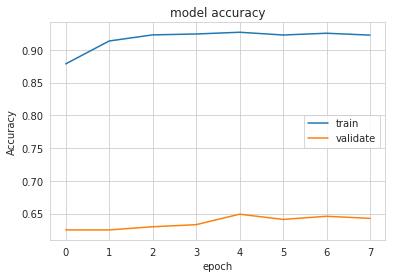

"  \nif keep_training:\n  # After Transfer Learning, let's open up a few layers for continued education.\n  unlock_layers(11)\n  model.compile(SGD(learning_rate=1e-9, momentum=0.9),\n                loss='categorical_crossentropy',\n                metrics=['accuracy'])\n  model.summary()\n\nif is_pretrained:\n  model.load_weights('{}/v_acc-0.76-v_loss-0.51.hdf5'.format(main_model_dir))\n"

In [14]:
def unlock_layers(num_layers):
  for l in range(311 - num_layers, 311):
      model.layers[l].trainable = True

def train_model():
  hist = model.fit_generator(train_generator,
                             steps_per_epoch=len(train_generator),
                             epochs=10,
                             verbose=1,
                             callbacks=callbacks,
                             validation_data=test_generator,
                             validation_steps=len(test_generator),
                             class_weight=class_w)

  plt.plot(hist.history['acc'])
  plt.plot(hist.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validate'], loc='best')
  plt.show()

train_model()

"""  
if keep_training:
  # After Transfer Learning, let's open up a few layers for continued education.
  unlock_layers(11)
  model.compile(SGD(learning_rate=1e-9, momentum=0.9),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  model.summary()

if is_pretrained:
  model.load_weights('{}/v_acc-0.76-v_loss-0.51.hdf5'.format(main_model_dir))
"""


In [15]:
vl_score = model.predict_generator(test_generator)

classes = ['Normal', 'Pneumonia']
print(classification_report(test_generator.classes,
                            np.argmax(vl_score, axis=1),
                            target_names=classes))
print('AUC: ', roc_auc_score(test_generator.classes,
                             np.argmax(vl_score, axis=1)))

              precision    recall  f1-score   support

      Normal       0.93      0.06      0.11       234
   Pneumonia       0.64      1.00      0.78       390

    accuracy                           0.65       624
   macro avg       0.79      0.53      0.45       624
weighted avg       0.75      0.65      0.53       624

AUC:  0.5286324786324786


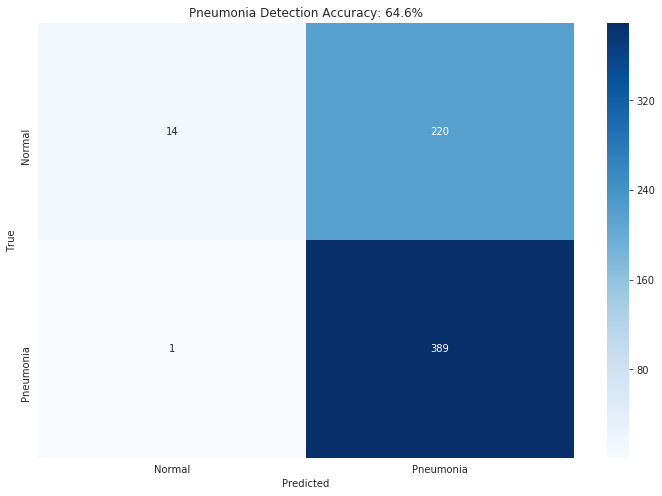

In [16]:
acc = accuracy_score(test_generator.classes, np.argmax(vl_score, axis=1))*100.0
cm = confusion_matrix(test_generator.classes, np.argmax(vl_score, axis=1))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(12,8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Pneumonia Detection Accuracy: {0:.1f}%'.format(acc))
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# run model again to improve
